In [10]:
!pwd

/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/linear_absorption_spectra


In [1]:
import numpy as np
import sys
sys.path.append('/home/kranka/github_repos/kranka_ucm/scripts/')
from gauss_hf import *
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


# dipole moment conversion factor: 1 debye = 0.393430307 a.u.
DtoAU = 0.39343
AUtoD = 1./DtoAU
# energy conversion factor: 1 a.u. = 27.211396 eV
AUtoEV = 27.211396
EVtoAU = 1./AUtoEV
# time: 1 a.u. = 0.02418884254 fs
AUtoFS = 0.02418884
FStoAU = 1./AUtoFS

In [3]:
dt_au = 0.08268
dt_fs = dt_au * AUtoFS
syst = [1, 2, 3,]
lrtdhf_dE = [8.9475, 7.0531, 5.989,]

In [5]:
# RT-TDHF delta-kick linear absorption spectra
traj_txt, traj_dir = [], []
for i in glob.glob('./time_dipole.*maxocc*.txt',):
    direc = os.path.abspath(i)
    traj_txt.append(os.path.abspath(direc))
    traj_dir.append(direc.split('time_dipole')[0])
pic_str = './off-res_peakshift.png'
print(traj_txt,traj_dir)
tdip_arr = []
for i in traj_txt:
    tdips = np.loadtxt(i)
    tdipnorm = np.linalg.norm(tdips[:,1:],axis=1)
    print(tdipnorm.shape)
    tdip_arr.append(np.array([tdipnorm,tdips[:,0]]))
    # print(tdip_arr[-1].shape)

['/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/linear_absorption_spectra/time_dipole.sys1-h_maxoccLUMO_steps=40000.txt', '/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/linear_absorption_spectra/time_dipole.sys2-h_maxoccLUMO_steps=40000.txt', '/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/linear_absorption_spectra/time_dipole.sys3-h_maxoccLUMO_steps=40000.txt'] ['/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/linear_absorption_spectra/', '/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/linear_absorption_spectra/', '/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/linear_absorption_spectra/']
(41805,)
(42106,)
(44356,)


(2, 41805)
1 41805
-1.868765542271075
18401 18401
(2, 42106)
1 42106
-1.8692213122929764
18552 18552
(2, 44356)
1 44356
-1.8724073994275872
19677 19677
[8.9475]
[7.0531]
[5.989]


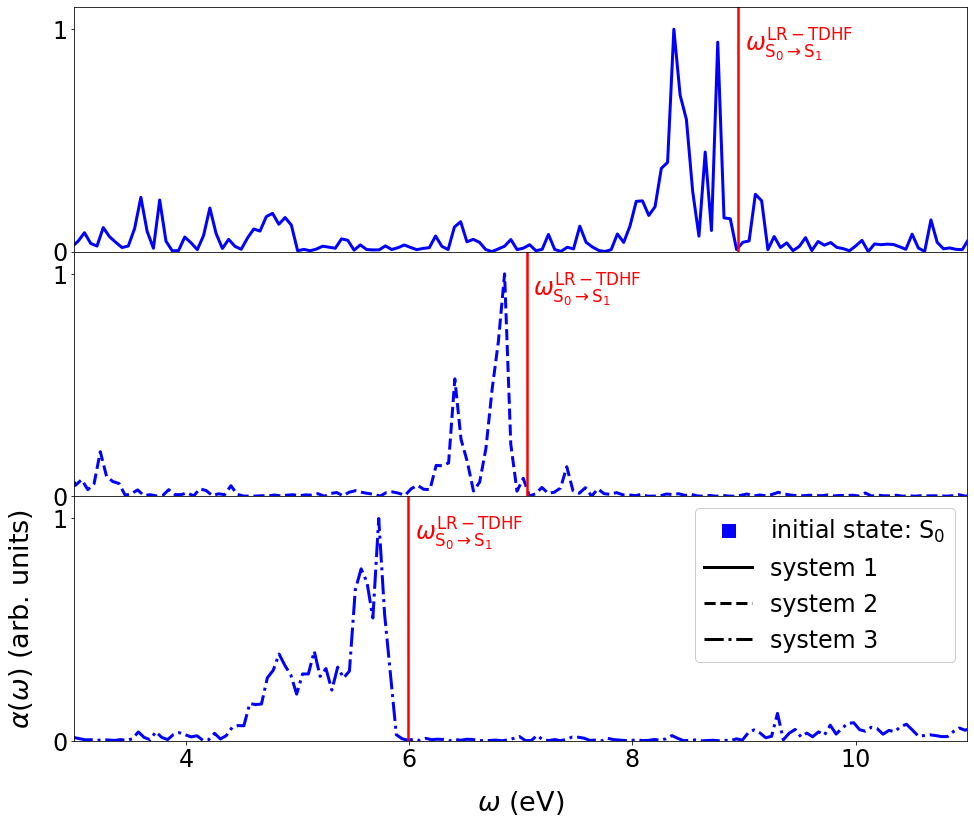

In [9]:
x, y = [], []
SY = 0
for SY in range(len(tdip_arr)):
    tdip = [tdip_arr[SY]]
    print(tdip[0].shape)
    M = len(tdip)
    N = tdip[0].shape[1]
    print(M,N)
    dip_acf = []
    offset = 5000
    for i in range(M):
        tdip_dum = tdip[i][0,offset:]
        tdip1 = np.correlate(tdip_dum, tdip_dum, 'full')
        tdip1 = tdip1[int(tdip1.size/2):]
        tdip1 /= tdip1[0]
        dip_acf.append(tdip1)
    '''
    plt.plot(range(dip_acf[0].size), dip_acf[0], label='autocorrelation')
    plt.legend()
    plt.show()
    # '''
    freq = np.fft.rfftfreq(dip_acf[0].size, d=dt_au)
    dv_au = 1/(dt_au*dip_acf[0].size)
    freq = freq * 2*np.pi * AUtoEV
    freq = freq[1:-1]
    x.append(freq)
    spec_tdhf = []
    for acf in dip_acf:
        spec1 = np.fft.rfft(acf) * ((8 * np.pi**3)  / 137.036) #* freq
        spec1 = np.real(spec1[1:-1])
        spec1 -= np.amin(spec1)
        spec1 = spec1 / np.amax(spec1[10:])
        spec_tdhf.append(spec1)
        y.append(spec1)
    print(((freq[1] - freq[0])) - 1/((2*np.pi)*dt_au))
    print(freq.size, spec_tdhf[0].size)
x_lo, x_hi = 3., 11.
dx = 2. #(x_hi - x_lo)/10
y_lo, y_hi = 0.0, 1.1
# dy = 0.5
fig = plt.figure(figsize=(16,13.5))
l2s = 16/47.25
plt.rcParams.update({
    "axes.labelsize": 45*l2s,
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
    "xtick.labelsize": 70*l2s,
    "ytick.labelsize": 70*l2s,
})
gs = gridspec.GridSpec(len(tdip_arr), 1, hspace=0, figure=fig,)
axs = gs.subplots(sharex=True, sharey=True)
plt.xlabel(r'$\omega$ (eV)', fontdict={'size': 80*l2s}, labelpad=50*l2s)
axs[2].set_ylabel(r'$\alpha(\omega)$ (arb. units)', fontdict={'size': 80*l2s}, labelpad=50*l2s)
plt.xlim(x_lo,x_hi); plt.xticks(np.arange(x_lo+1, x_hi, step=dx))
plt.ylim(y_lo,y_hi); plt.yticks(np.arange(y_lo, y_hi, step=1))
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
lns = ['solid', 'dashed', 'dashdot',]
lbl = ['system 1', 'system 2', 'system 3']
l3 = [
    Line2D([0], [0], marker='s', color='w', label=r'initial state: $\mathrm{S}_0$', markerfacecolor='b', markersize=15),
]
SY = 0
for ax in axs:
    ax.label_outer()
    dim = min(x[SY].shape[0],y[SY].shape[0])
    ax.plot(x[SY][:dim], y[SY][:dim], linestyle=lns[SY], lw=3, color='b')
    ab = np.array([lrtdhf_dE[SY]])
    print(ab)
    ax.stem(ab[0], np.ones(1)+0.5, linefmt='r-',)[1].set_linewidth(2.5)
    ax.text(ab[0]+0.15*((x_hi - x_lo)/20), 0.9, r'$\omega^{\mathrm{LR-TDHF}}_\mathrm{\mathrm{S}_0 \rightarrow \mathrm{S}_1}$', fontsize = 70*l2s, color='r')
    l3.append(Line2D([0], [0], color='k', linestyle=lns[SY], lw=3, label=lbl[SY]))
    SY += 1
ax.legend(fontsize=70*l2s,handles=l3,framealpha=1.0,loc='best')
# fig.savefig(pic_str)
plt.show()